In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
num_rep = 3

In [7]:
def read_fault(file_name):
    workers = []
    throughput_all = []
    throughput = []
    times = []
    fault_rate = []
    graph_size = 0
    with open(file_name, "r") as in_file:
        for l in in_file:
            if l[0] == '=':
                break
            elif l.split()[0] == 'results':
                continue
            elif l.split(',')[0] == 'failure':
                fault_rate.append(float(l.split(',')[1]))
                if times != []:
                    for t in times:
                        throughput.append([graph_size * 10  / (float(x) / 1000 ) for x in t])
                    throughput_all.append(throughput)
                    throughput = []
                    times = []
                continue
            elif l.split()[0] == 'graph':
                graph_size = int(l.split(' ')[2])
                print(f"graph size is {graph_size}")
                continue
            line = l.strip(" {}[],\n")
            line = line.replace("]", "")
            line = line.replace(" ", "")
            data = line.split(",")
            if not int(data[-1]) in workers:
                workers.append(int(data[-1]))
            times.append(data[0: -1])
    for t in times:
        throughput.append([graph_size * 10  / (float(x) / 1000 ) for x in t])
    throughput_all.append(throughput)
    return (throughput_all, workers, fault_rate, graph_size)

In [8]:

def func(x, a, b, c, d):
    return a * (x**3) + b*(x**2) + c * x + d


def plot(throughput, workers, ax, fault):
    # confidence interval
    max_throughputs = [np.max(t) for t in throughput]
    min_throughputs = [np.min(t) for t in throughput]
    mean_throughputs = [np.mean(t) for t in throughput]

    # create flattened version
    workers_flat = np.array([[w] * num_rep for w in workers]).flatten()
    throughput_flat = throughput.flatten()

    # fit the curve
    popt, pcov = curve_fit(func, workers, mean_throughputs)

    ax.scatter(workers_flat, throughput_flat, s=6, alpha=0.8)
    ax.fill_between(workers, min_throughputs, max_throughputs, alpha=0.3)
    ax.plot(workers, func(workers, *popt), label=f"fault rate {fault}")

In [9]:
throughput_all, workers, fault_rate, graph_size = read_fault('../results/time_worker.txt')

graph size is 150


In [16]:
len(throughput_all[0])

15

In [10]:
def plot_all(throughput_all, workers, graph_size, fault_rate):
  fig, ax = plt.subplots()
  fig.set_size_inches(18, 15)
  ax.set_title(f"throughput of tc against #workers on graph size {graph_size}")
  ax.set_xlabel("number of workers")
  ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.set_ylabel("throughput")
  for i, throughput in enumerate(throughput_all):
    plot(np.array(throughput), np.array(workers), ax, fault_rate[i])
  ax.legend()


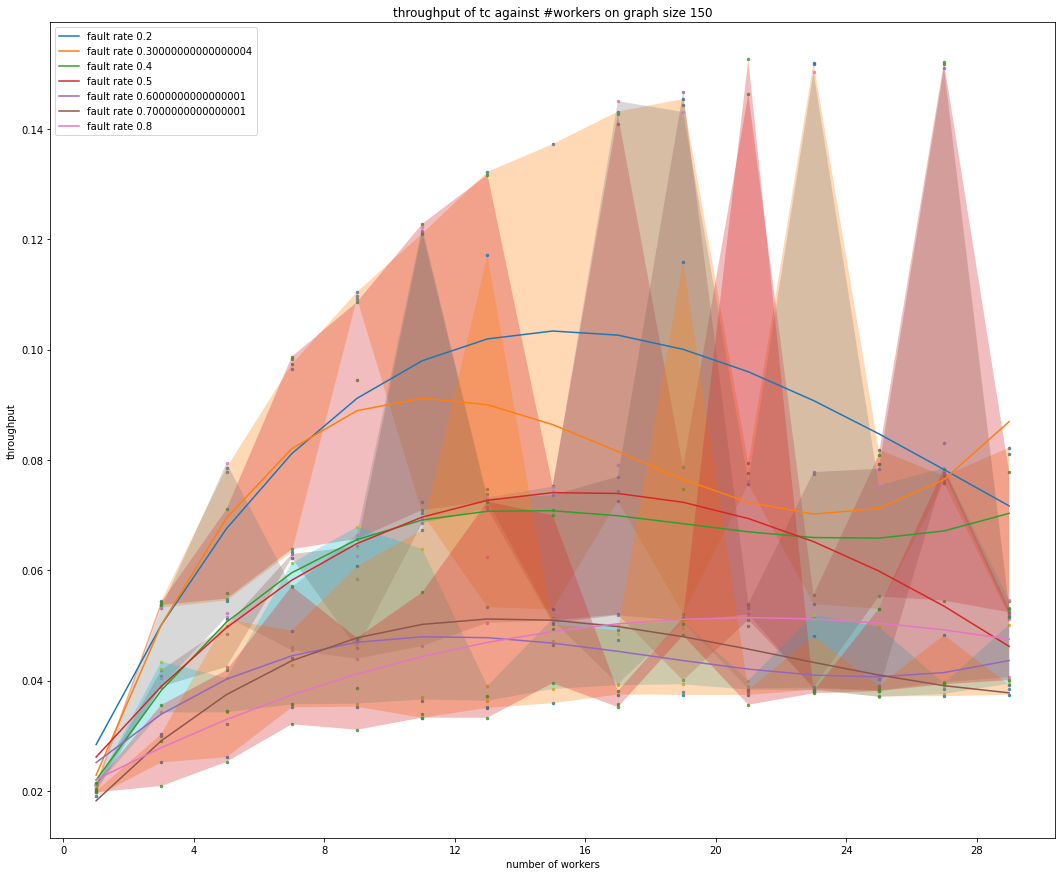

In [19]:
plot_all(throughput_all, workers, graph_size, fault_rate)